In [1]:
from gcms_spectra_gnn.spectra_dataset import MoleculeModel
import json
from torch.utils.data import DataLoader, Dataset
import torch
import os
import numpy as np
from scipy.sparse import coo_matrix

In [2]:
import dgl

Using backend: pytorch


In [3]:
import networkx as nx

In [4]:
library_path = 'data/preprocessed_micro/'

In [5]:
with open(os.path.join(library_path, 'index.json')) as fh:
    library_info = json.load(fh)

In [7]:
library_info = [info for info in library_info if os.path.exists(library_path + info['FP_PATH'])]

In [8]:
# apparently weird stuff happened where paths were saved but had no smiles...
new_library_info = []
for info in library_info:
    try:
        MoleculeModel.load(library_path + info['FP_PATH'])
        new_library_info.append(info)
    except KeyError:
        continue
library_info = new_library_info

In [9]:
len(library_info)

98

In [10]:
class MoleculeJSONDataset(Dataset):
    
    def __init__(self, library, root_dir, graph_transform=None, label_transform=None):
        self.library = [entry for entry in library if entry.get('FP_PATH')]
        self.root_dir = root_dir
        self.graph_transform = graph_transform
        self.label_transform = label_transform
        
    def __len__(self):
        return len(self.library)
    
    def __getitem__(self, idx):     
        model = MoleculeModel.load(
                os.path.join(self.root_dir, self.library[idx]['FP_PATH']))
        if self.graph_transform:
            X = self.graph_transform(model)
        else:
            X = model.to_safe_dict()
        if self.label_transform:
            y = self.label_transform(model)
        else:
            y = model.data
            
        return X, y
        

In [11]:
model = MoleculeModel.load(os.path.join(library_path, library_info[0]['FP_PATH']))

In [12]:
# TODO what are reasonable min_ and max_ values?
# Do we need to sum normalize or anything like that?
def one_hot_spectrum_encoder(model, min_=20, max_=500):
    """
    Parameters
    ----------
    min_ : int 
        Lowest allowed m/z. Values lower are excluded.
    max_ : int
        Highest allowed m/z. Values higher are excluded.
        
    Returns
    -------
    torch.tensor
        Encoding of the spectrum
        
    """
    models = [model]
    y = np.zeros([len(models), max_ - min_ + 1])
    for n_mod, model in enumerate(models):
        for i, idx in enumerate(model.data[0, :]):
            idx = int(idx)
            if ((idx >= min_) and (idx <= max_)):
                y[n_mod, idx - min_] = model.data[1, i]
    return torch.tensor(y)

In [48]:
# DEFAULT_ELEMENTS = ['H', 'C', 'N', 'O', 'F']
DEFAULT_ELEMENTS = ['H', 'C', 'N', 'O', 'F', 'S', 'Cl', 'Br', 'I', 'P']

def ohe_molecules(symbols, elements=None):
    # TODO this might error if we get something not in elements
    # Be more explicit about error check
    if elements is None:
        elements = DEFAULT_ELEMENTS
    positions = np.zeros(len(symbols)).astype(int)
    for i, atom in enumerate(symbols):
        positions[i] = elements.index(atom)
    ohe = np.zeros((len(symbols), len(elements)))
    ohe[np.arange(len(positions)), positions] = 1
    return torch.tensor(ohe)
    

In [49]:
ohe_molecules(['H', 'C', 'I', 'Br'])

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)

In [63]:
def basic_dgl_encoder(model):
    G = dgl.from_scipy(coo_matrix(model.bonds))
    # TODO figure out some features!
    G.ndata['mol_ohe'] = ohe_molecules(model.symbols)
    return G
        

In [64]:
G = basic_dgl_encoder(model)

In [65]:
y = one_hot_spectrum_encoder(model)

In [67]:
dataset = MoleculeJSONDataset(library_info, library_path,
                              label_transform=one_hot_spectrum_encoder,
                              graph_transform=basic_dgl_encoder,
                              )

In [59]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

# copy pasta from dgl tutorial
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)
        
class Net(nn.Module):
    def __init__(self, input_features, output_features):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(input_features, 16)
        self.layer2 = GCNLayer(16, output_features)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x

net = Net(len(DEFAULT_ELEMENTS), 8)
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=10, out_features=16, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=8, bias=True)
  )
)


In [70]:
net(G, G.ndata['mol_ohe'].float())

tensor([[ 0.7396,  0.6208,  0.9945,  0.0070,  0.1091,  0.0986, -0.2371,  0.0289],
        [ 1.1897,  0.6502,  1.6978, -0.1110,  0.3392, -0.0874, -0.2146, -0.4690],
        [ 0.0042,  0.2478,  0.3331,  0.1709, -0.0614, -0.0354, -0.2909,  0.2898],
        [ 0.4118,  0.4775,  0.8838,  0.1212,  0.0879, -0.1112, -0.4445,  0.1204],
        [ 1.4148,  0.7967,  1.8738, -0.0911,  0.3175, -0.0663, -0.1451, -0.6126],
        [ 1.4612,  0.8343,  2.0543, -0.0928,  0.3644, -0.1224, -0.3072, -0.5742],
        [ 2.1347,  1.0681,  2.8298, -0.1245,  0.5632, -0.2226, -0.2369, -1.2041],
        [ 1.7948,  0.8703,  2.4380, -0.1606,  0.4031, -0.0641, -0.1497, -0.8584],
        [ 2.0566,  1.0964,  2.6688, -0.0750,  0.5776, -0.2708, -0.2735, -1.1937],
        [ 1.3591,  0.8522,  1.9018, -0.0831,  0.2486, -0.0076, -0.1905, -0.5135],
        [ 1.3935,  0.8024,  1.8954, -0.0070,  0.3751, -0.2051, -0.2408, -0.7505],
        [ 0.1275,  0.3378,  0.5264,  0.1437, -0.0531, -0.0794, -0.2302,  0.1141],
        [ 1.3591

In [80]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.cat(labels)

data_loader = DataLoader(dataset, batch_size=32, shuffle=True,
                         collate_fn=collate)

In [81]:
def iter_epoch():
    for iter, (bg, label) in enumerate(data_loader):
        pass

In [82]:
iter_epoch()

In [60]:
%timeit iter_epoch()

30.7 s ± 672 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
i, (bg, label) = next(enumerate((data_loader)))

Graph(num_nodes=1365, num_edges=2800,
      ndata_schemes={}
      edata_schemes={})

In [27]:
bg.batch_size

32

In [28]:
bg

Graph(num_nodes=1373, num_edges=2784,
      ndata_schemes={}
      edata_schemes={})

In [29]:
h1 = bg.in_degrees().view(-1, 1).float()
h3 = h2 = h1 
h = torch.cat([h1, h2, h3], 1)
bg.ndata['h'] = h
dgl.mean_nodes(bg, 'h')

tensor([[2.0000, 2.0000, 2.0000],
        [2.0588, 2.0588, 2.0588],
        [1.8571, 1.8571, 1.8571],
        [2.0000, 2.0000, 2.0000],
        [1.9286, 1.9286, 1.9286],
        [2.0000, 2.0000, 2.0000],
        [2.0000, 2.0000, 2.0000],
        [2.0000, 2.0000, 2.0000],
        [2.0392, 2.0392, 2.0392],
        [2.0000, 2.0000, 2.0000],
        [2.0488, 2.0488, 2.0488],
        [2.0000, 2.0000, 2.0000],
        [2.0556, 2.0556, 2.0556],
        [2.0741, 2.0741, 2.0741],
        [2.0625, 2.0625, 2.0625],
        [2.0000, 2.0000, 2.0000],
        [2.0370, 2.0370, 2.0370],
        [2.1053, 2.1053, 2.1053],
        [2.0000, 2.0000, 2.0000],
        [2.0392, 2.0392, 2.0392],
        [2.0000, 2.0000, 2.0000],
        [2.1200, 2.1200, 2.1200],
        [2.0000, 2.0000, 2.0000],
        [2.0952, 2.0952, 2.0952],
        [2.0000, 2.0000, 2.0000],
        [2.0571, 2.0571, 2.0571],
        [2.0000, 2.0000, 2.0000],
        [2.0000, 2.0000, 2.0000],
        [2.0606, 2.0606, 2.0606],
        [2.039

In [175]:
h.shape

torch.Size([1304, 1])

In [96]:
g = dataset[:4][0][3]

In [7]:
# https://docs.dgl.ai/en/0.4.x/_modules/dgl/data/minigc.html#MiniGCDataset

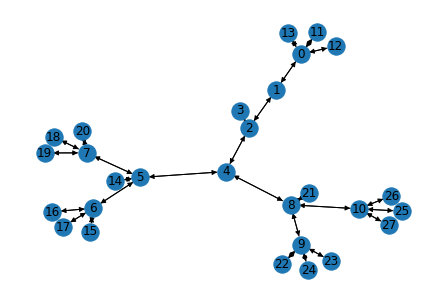

In [97]:
nx.draw(g.to_networkx(), with_labels=True)